In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mpmath as mp
from scipy.optimize import curve_fit
from astropy import units as u
from astropy import constants as const
from jupyterthemes import jtplot #These two lines can be skipped if you are not using jupyter themes
jtplot.reset()

In [2]:
r0 = 10.0*u.kpc
z0 = 1.*u.kpc
n0 = 300./(u.cm)**(3)
Dl = 705.4019455128785*u.Mpc
Ds = 1760.3796178766652*u.Mpc
Dls = 1375.6149203241862*u.Mpc

In [3]:
theta_0 = (r0/Dl).decompose()*u.rad.to('arcsec', equivalencies=u.dimensionless_angles()) 
print('Angular scale radius (theta_0 = r0/Dl): ',theta_0, 'arcsec')

Angular scale radius (theta_0 = r0/Dl):  2.9240748137875747 arcsec


## Primero chequeemos el integrador

### Integral del paper con plasma esferico haciendo cambio de variable

In [4]:
def Ne(theta,n0,R0):

    integ = lambda z_tilde: mp.exp(-np.sqrt(theta**2/theta_0.value**2+z_tilde**2))
    
    upper_limit_0 = (Dls/R0).decompose().value
    lower_limit_0 = 0.0
    integ_0 = mp.quad(integ,[lower_limit_0,upper_limit_0])
    print('integ_0 =', integ_0)
    
    upper_limit_1 = 0.0
    lower_limit_1 = -(Dl/R0).decompose().value
    integ_1 = mp.quad(integ,[lower_limit_1,upper_limit_1])
    print('integ_1 =', integ_1)
    
    return (n0*R0).decompose().to(u.cm**(-2))*(integ_0+integ_1)

In [5]:
Ne_test = Ne(1,n0,r0)
print('Ne', Ne_test)

integ_0 = 0.899138816150974
integ_1 = 0.899138816150977
Ne 1.66467149258745e+25 1 / cm2


### Integral del paper con plasma esférico sin hacer cambio de variable

In [6]:
def Ne(theta,n0,r0):
    
    integ = lambda z_tilde: mp.exp(-np.sqrt(theta**2*Dl.decompose().value**2+z_tilde**2)/r0)
    
    upper_limit_0 = Dls.decompose().value
    lower_limit_0 = 0.0
    integ_0 = mp.quad(integ,[lower_limit_0,upper_limit_0])
    print('integ_0 =', integ_0)

    upper_limit_1 = 0.0
    lower_limit_1 = -Dl.decompose().value
    integ_1 = mp.quad(integ,[lower_limit_1,upper_limit_1])
    print('integ_1 =', integ_1)
    
    return ((n0*(integ_0+integ_1))*u.m**(-2)).to(u.cm**(-2))

In [7]:
Ne_test = Ne(1*u.arcsec.to('rad'), n0.decompose().value, r0.decompose().value)
print('Ne', Ne_test)

integ_0 = 2.77445248764575e+20
integ_1 = 2.77445248764576e+20
Ne 1.6646714925874513e+25 1 / cm2


### Rotated Galaxy

The gaussian edge-wise plasma profile has the form
$$
n(r,z) = n_{0}e^{-\frac{r}{r_{0}}}e^{-(\frac{z}{z_0})^{2}} \\
r = \sqrt{x^{2} + y^{2}} .
$$

The x direction is the line of sight. Rotating this distribution through the z-direction does nothing, and through the x-direction amounts to rotate the source position and the orientation of sight. We the rotate it through the y-direction. 

<div>
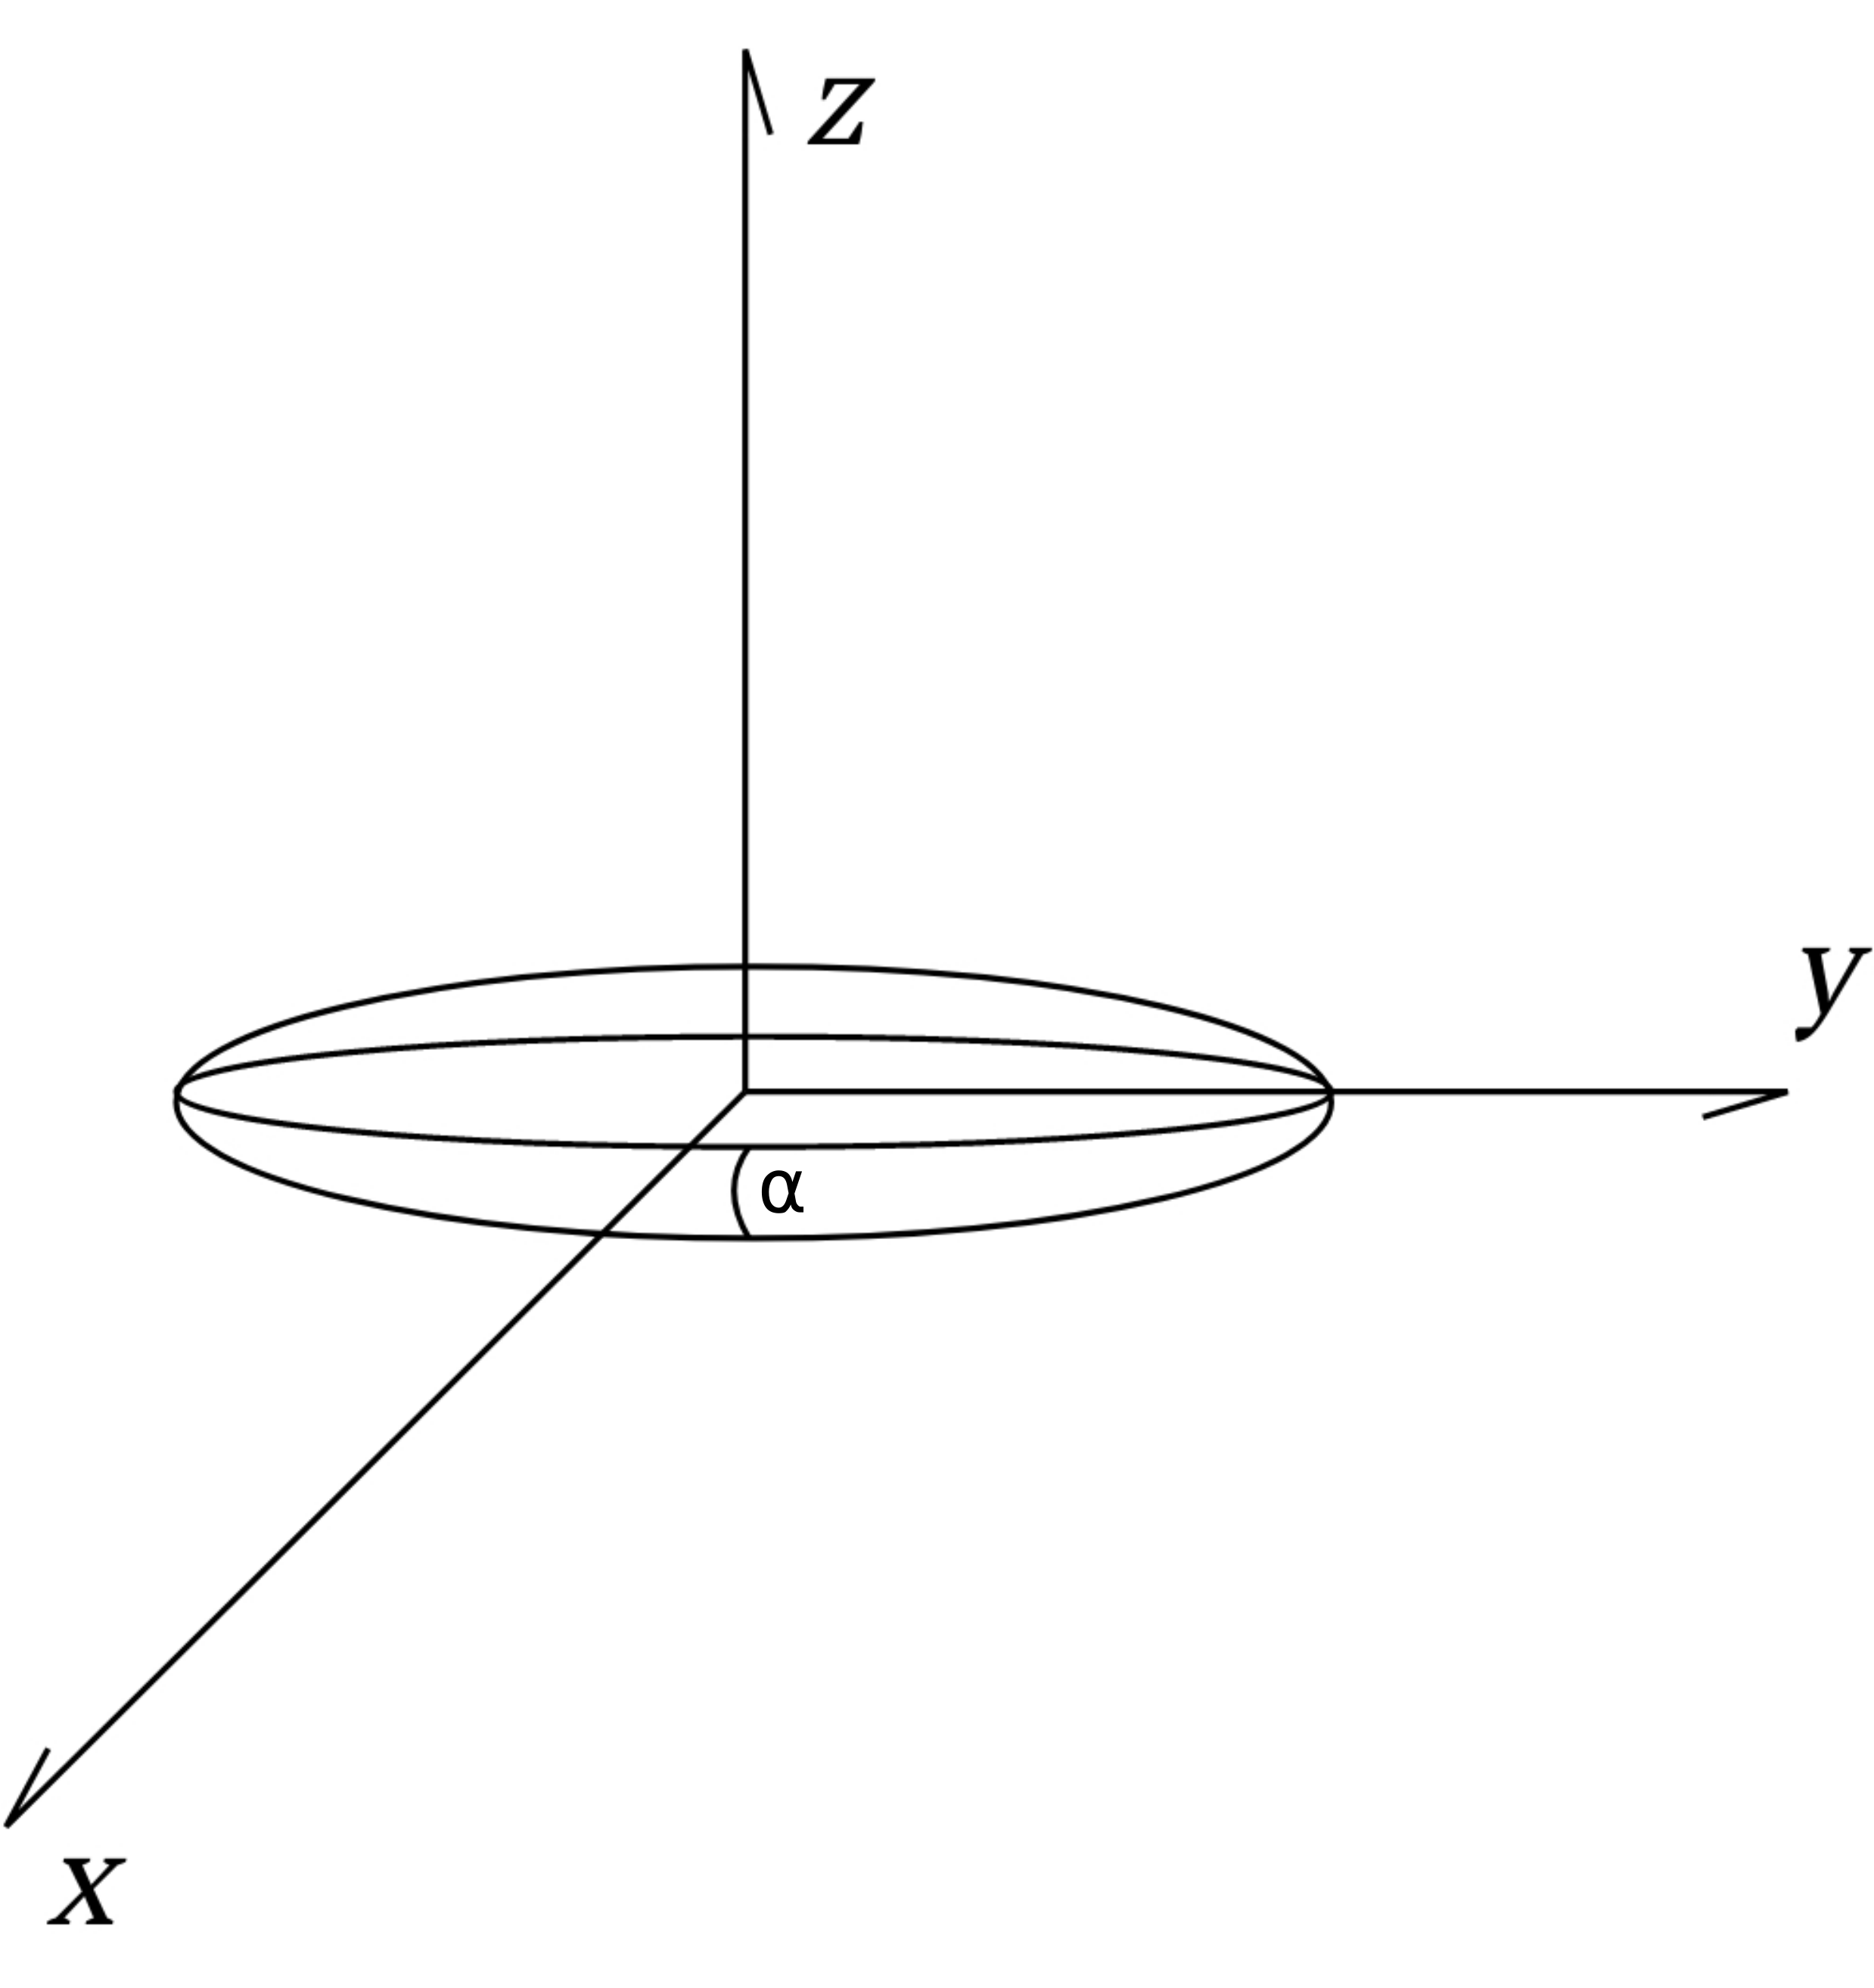
</div>
Me make

$$
z' = zcos\alpha - xsin\alpha \\
x' = zsin\alpha + xcos\alpha \\
z'^{2} = z^{2}cos^{2}\alpha + x^{2}sin^{2}\alpha - 2xzcos\alpha sin\alpha \\
x'^{2} = z^{2}sin^{2}\alpha + x^{2}cos^{2}\alpha + 2xzcos\alpha sin\alpha \\
n_{\alpha}(x,y,z) = n(x',y,z') = n_{0} exp( -\frac{1}{r_{0}} \sqrt{z^{2}sin^{2}\alpha + x^{2}cos^{2}\alpha + 2xzcos\alpha sin\alpha + y^{2}} ) exp( -(\frac{zcos\alpha}{z_{0}})^{2} ) exp( -(\frac{xsin\alpha}{z_{0}})^{2} ) exp (\frac{2xzcos\alpha sin\alpha}{z_{0}^{2}})
$$


In [8]:
def Ne(y,z,n0,r0,z0,alpha,Dl,Dls):

    integ = lambda x: mp.exp( -1/r0*mp.sqrt( z**2*mp.sin(alpha)**2 + x**2*mp.cos(alpha)**2 +
                                                     2*x*z*mp.cos(alpha)*mp.sin(alpha) + y**2) )  * mp.exp( -(z*mp.cos(alpha)/z0)**2 ) \
                                                     *mp.exp( -(x*mp.sin(alpha)/z0)**2 ) *mp.exp(2*x*z*mp.cos(alpha)*mp.sin(alpha)/z0**2)
    
    upper_limit_0 = Dls
    lower_limit_0 = 0.0
    integ_0 = mp.quad(integ,[lower_limit_0,upper_limit_0])
    print('integ_0 =', integ_0)
    
    upper_limit_1 = 0.0
    lower_limit_1 = -Dl
    integ_1 = mp.quad(integ,[lower_limit_1,upper_limit_1])
    print('integ_1 =', integ_1)
    
    return ((n0*(integ_0+integ_1))*u.m**(-2)).to(u.cm**(-2))

Test in a particular point

In [9]:
phi = np.pi/1
y = np.cos(phi)*1*u.arcsec*Dl
z = np.sin(phi)*1*u.arcsec*Dl
alpha = 27.*np.pi/180.

In [10]:
print('Ne =' ,Ne(y.decompose().value  ,   z.decompose().value,   n0.decompose().value,   r0.decompose().value,
   z0.decompose().value,   alpha,   Dl.decompose().value,   Dls.decompose().value))

integ_0 = 4.17308712362436e+19
integ_1 = 4.17308712363157e+19
Ne = 2.503852274176777e+24 1 / cm2


In [11]:
phi = 3/2*np.pi
y = np.cos(phi)*3*u.arcsec*Dl
z = np.sin(phi)*3*u.arcsec*Dl

Ne(y.decompose().value  ,   z.decompose().value,   n0.decompose().value,   r0.decompose().value,
   z0.decompose().value,   alpha,   Dl.decompose().value,   Dls.decompose().value)

integ_0 = 5.58693170063725e-19
integ_1 = 1.2600654287006e+19


<Quantity 3.78019629e+23 1 / cm2>

## Do the fitting

## Approach scipython.com - Now the y-z  plane is x-y.

In [12]:
# The two-dimensional domain of the fit.
x = np.arange(-3.,3.,0.1)*u.arcsec*Dl
y = np.arange(-3.,3.,0.1)*u.arcsec*Dl
x = x.decompose().value
y = y.decompose().value
X, Y = np.meshgrid(x, y)

In [13]:
# Our function to fit (the data to be fitted)
import time

def f(x,y):
    Ne_ = np.frompyfunc(Ne, 8, 1)
    output = Ne_(x,   y,   n0.decompose().value,   r0.decompose().value,
   z0.decompose().value,   alpha,   Dl.decompose().value,   Dls.decompose().value)
    for i in range(len(output)):
        for j in range(len(output)):
            output[i][j] = output[i][j].value                  
    return output

time1 = time.time()
Z = f(X, Y)
time2 = time.time()
print('time: ',(time2-time1)/60.,'minutes')

integ_0 = 2.85192689693589e-19
integ_1 = 1.00552700928407e+19
integ_0 = 2.94249612931036e-19
integ_1 = 1.01984847493839e+19
integ_0 = 3.03539046315852e-19
integ_1 = 1.03396041919677e+19
integ_0 = 3.13059747570006e-19
integ_1 = 1.04784132619473e+19
integ_0 = 3.22809201098053e-19
integ_1 = 1.06146942950828e+19
integ_0 = 3.32783390403711e-19
integ_1 = 1.07482277191596e+19
integ_0 = 3.42976533311806e-19
integ_1 = 1.0878792691758e+19
integ_0 = 3.53380774184289e-19
integ_1 = 1.10061677763744e+19
integ_0 = 3.63985826656539e-19
integ_1 = 1.11301316546188e+19
integ_0 = 3.7477855984226e-19
integ_1 = 1.12504638717168e+19
integ_0 = 3.857425205807e-19
integ_1 = 1.13669456120454e+19
integ_0 = 3.96857384316118e-19
integ_1 = 1.14793605009306e+19
integ_0 = 4.08098327893999e-19
integ_1 = 1.15874954284441e+19
integ_0 = 4.19435319359561e-19
integ_1 = 1.16911413904614e+19
integ_0 = 4.30832323370686e-19
integ_1 = 1.1790094341798e+19
integ_0 = 4.42246426954737e-19
integ_1 = 1.18841560558228e+19
integ_0 = 4.5

integ_1 = 1.39068566688355e+19
integ_0 = 4.81271813564431e-14
integ_1 = 1.40313741189337e+19
integ_0 = 4.94305179215544e-14
integ_1 = 1.41498456320647e+19
integ_0 = 5.07329759610569e-14
integ_1 = 1.42620133883993e+19
integ_0 = 5.20279394602454e-14
integ_1 = 1.43676290650003e+19
integ_0 = 5.33076191764117e-14
integ_1 = 1.44664550605774e+19
integ_0 = 5.45629261705182e-14
integ_1 = 1.45582656994672e+19
integ_0 = 5.57833651243703e-14
integ_1 = 1.46428484040738e+19
integ_0 = 5.69569684594477e-14
integ_1 = 1.47200048248597e+19
integ_0 = 5.80703001683756e-14
integ_1 = 1.47895519169865e+19
integ_0 = 5.91085659990548e-14
integ_1 = 1.48513229528806e+19
integ_0 = 6.00558715902786e-14
integ_1 = 1.49051684603438e+19
integ_0 = 6.08956681517159e-14
integ_1 = 1.49509570763404e+19
integ_0 = 6.16114109916658e-14
integ_1 = 1.49885763072809e+19
integ_0 = 6.21874250583832e-14
integ_1 = 1.5017933187465e+19
integ_0 = 6.26099234622474e-14
integ_1 = 1.50389548283447e+19
integ_0 = 6.28680680532944e-14
integ_1 =

integ_0 = 1.57427597403228e-9
integ_1 = 1.68928313388114e+19
integ_0 = 1.58128970293986e-9
integ_1 = 1.6908210683746e+19
integ_0 = 1.58365240652551e-9
integ_1 = 1.6913341903608e+19
integ_0 = 1.58128970293986e-9
integ_1 = 1.6908210683746e+19
integ_0 = 1.57427597403228e-9
integ_1 = 1.68928313388114e+19
integ_0 = 1.56282585665805e-9
integ_1 = 1.68672467143199e+19
integ_0 = 1.54727084618515e-9
integ_1 = 1.68315278926597e+19
integ_0 = 1.52802649301978e-9
integ_1 = 1.6785773707495e+19
integ_0 = 1.50555687245078e-9
integ_1 = 1.67301100730405e+19
integ_0 = 1.48034204201605e-9
integ_1 = 1.66646891370694e+19
integ_0 = 1.45285200753214e-9
integ_1 = 1.65896882687034e+19
integ_0 = 1.42352841678556e-9
integ_1 = 1.65053088939737e+19
integ_0 = 1.392773503499e-9
integ_1 = 1.64117751938122e+19
integ_0 = 1.360944905398e-9
integ_1 = 1.6309332680483e+19
integ_0 = 1.32835473076119e-9
integ_1 = 1.61982466695046e+19
integ_0 = 1.29527138976712e-9
integ_1 = 1.60788006648103e+19
integ_0 = 1.26192301597609e-9
int

integ_0 = 1.54157138702112e-5
integ_1 = 1.90044341026061e+19
integ_0 = 1.50052971324814e-5
integ_1 = 1.88418834723526e+19
integ_0 = 1.45955218635692e-5
integ_1 = 1.86696893288049e+19
integ_0 = 1.41882068031047e-5
integ_1 = 1.84883074115151e+19
integ_0 = 1.37848296747293e-5
integ_1 = 1.82982070479469e+19
integ_0 = 1.33865815696876e-5
integ_1 = 1.80998684719682e+19
integ_0 = 1.2994413831702e-5
integ_1 = 1.78937801976057e+19
integ_0 = 1.26090779195172e-5
integ_1 = 1.76804364704217e+19
integ_0 = 1.22311589909586e-5
integ_1 = 1.7460334816177e+19
integ_0 = 1.18611040323521e-5
integ_1 = 1.72339737036431e+19
integ_0 = 1.14992453358146e-5
integ_1 = 1.70018503356015e+19
integ_0 = 1.11458200563958e-5
integ_1 = 1.67644585792699e+19
integ_0 = 1.08009864915184e-5
integ_1 = 1.65222870446981e+19
integ_0 = 1.04648376331515e-5
integ_1 = 1.62758173171026e+19
integ_0 = 1.01374124570263e-5
integ_1 = 1.60255223467202e+19
integ_0 = 9.81870533658936e-6
integ_1 = 1.5771864997564e+19
integ_0 = 9.50867390331316e

integ_0 = 2.95981333136449
integ_1 = 1.83357531417554e+19
integ_0 = 3.05813305778609
integ_1 = 1.86797390737412e+19
integ_0 = 3.1593999309656
integ_1 = 1.90216722559293e+19
integ_0 = 3.26365775981282
integ_1 = 1.93609438173417e+19
integ_0 = 3.37094304991105
integ_1 = 1.96969195730667e+19
integ_0 = 3.48128317059155
integ_1 = 2.00289412517731e+19
integ_0 = 3.59469413070873
integ_1 = 2.03563280136793e+19
integ_0 = 3.71117787305767
integ_1 = 2.06783782752045e+19
integ_0 = 3.83071897494219
integ_1 = 2.09943718540337e+19
integ_0 = 3.95328061424622
integ_1 = 2.13035724451568e+19
integ_0 = 4.07879962519633
integ_1 = 2.16052304345451e+19
integ_0 = 4.20718042445813
integ_1 = 2.18985860524987e+19
integ_0 = 4.33828753504044
integ_1 = 2.2182872863324e+19
integ_0 = 4.47193637203536
integ_1 = 2.24573215819232e+19
integ_0 = 4.6078818813607
integ_1 = 2.27211642011479e+19
integ_0 = 4.74580454451715
integ_1 = 2.29736384064939e+19
integ_0 = 4.88529318950375
integ_1 = 2.32139922470244e+19
integ_0 = 5.02582

integ_1 = 2.83363727354508e+19
integ_0 = 11109.327338268
integ_1 = 2.85116055263832e+19
integ_0 = 11349.0235910046
integ_1 = 2.86650003111345e+19
integ_0 = 11568.5458488664
integ_1 = 2.87959199011941e+19
integ_0 = 11761.7422979615
integ_1 = 2.89038122934898e+19
integ_0 = 11921.9387035933
integ_1 = 2.89882168507786e+19
integ_0 = 12042.4744741612
integ_1 = 2.90487695738165e+19
integ_0 = 12117.5162087001
integ_1 = 2.90852073415098e+19
integ_0 = 12143.0155113166
integ_1 = 2.9097371016755e+19
integ_0 = 12117.5162087001
integ_1 = 2.90852073415098e+19
integ_0 = 12042.4744741612
integ_1 = 2.90487695738165e+19
integ_0 = 11921.9387035933
integ_1 = 2.89882168507786e+19
integ_0 = 11761.7422979615
integ_1 = 2.89038122934898e+19
integ_0 = 11568.5458488664
integ_1 = 2.87959199011941e+19
integ_0 = 11349.0235910046
integ_1 = 2.86650003111345e+19
integ_0 = 11109.327338268
integ_1 = 2.85116055263831e+19
integ_0 = 10854.8197236733
integ_1 = 2.83363727354508e+19
integ_0 = 10590.0026357904
integ_1 = 2.81400

integ_1 = 3.05337201895105e+19
integ_0 = 7849231.20699193
integ_1 = 3.01290334178972e+19
integ_0 = 7606980.28447573
integ_1 = 2.97085043737431e+19
integ_0 = 7370133.11534122
integ_1 = 2.92735986046604e+19
integ_0 = 7138926.08981395
integ_1 = 2.88257639299281e+19
integ_0 = 6913513.22210323
integ_1 = 2.83664217079944e+19
integ_0 = 6693983.89518647
integ_1 = 2.78969592206006e+19
integ_0 = 6480376.70004829
integ_1 = 2.74187231563492e+19
integ_0 = 6272690.28342913
integ_1 = 2.69330141560317e+19
integ_0 = 6070891.8940484
integ_1 = 2.64410823660652e+19
integ_0 = 5874924.14915639
integ_1 = 2.59441239345888e+19
integ_0 = 5684710.41748406
integ_1 = 2.54432783767439e+19
integ_0 = 5500159.12051616
integ_1 = 2.49396267308717e+19
integ_0 = 5321167.18339546
integ_1 = 2.44341904253342e+19
integ_0 = 5147622.81361183
integ_1 = 2.39279307758718e+19
integ_0 = 113469334.059819
integ_1 = 2.48166355195435e+19
integ_0 = 117316808.841136
integ_1 = 2.53730101934611e+19
integ_0 = 121287650.479277
integ_1 = 2.593

integ_0 = 44537555359.3137
integ_1 = 3.31034195190757e+19
integ_0 = 46033673667.3176
integ_1 = 3.37677311787243e+19
integ_0 = 47574854809.7963
integ_1 = 3.44241590565266e+19
integ_0 = 49161486520.6485
integ_1 = 3.50706939320955e+19
integ_0 = 50793717248.9191
integ_1 = 3.5705215515061e+19
integ_0 = 52471380999.7688
integ_1 = 3.63254988130785e+19
integ_0 = 54193898394.7091
integ_1 = 3.6929222982978e+19
integ_0 = 55960145339.5063
integ_1 = 3.75139829337127e+19
integ_0 = 57768277179.723
integ_1 = 3.80773039201208e+19
integ_0 = 59615491185.3078
integ_1 = 3.86166593172779e+19
integ_0 = 61497702994.0496
integ_1 = 3.91294916930888e+19
integ_0 = 63409102447.6956
integ_1 = 3.96132371991184e+19
integ_0 = 65341540245.6809
integ_1 = 4.00653531751283e+19
integ_0 = 67283678753.2613
integ_1 = 4.04833487119536e+19
integ_0 = 69219820132.8358
integ_1 = 4.08648177435526e+19
integ_0 = 71128311412.362
integ_1 = 4.12074740490661e+19
integ_0 = 72979444925.3038
integ_1 = 4.15091873502922e+19
integ_0 = 74732887

integ_1 = 4.92249518801405e+19
integ_0 = 11760252095362.6
integ_1 = 4.91250545265529e+19
integ_0 = 11570989177333.7
integ_1 = 4.89595864939862e+19
integ_0 = 11336093667775.9
integ_1 = 4.87300554221375e+19
integ_0 = 11070919809913.0
integ_1 = 4.84385073026573e+19
integ_0 = 10787019712965.4
integ_1 = 4.8087467590897e+19
integ_0 = 10492618633178.1
integ_1 = 4.76798727872945e+19
integ_0 = 10193433563302.8
integ_1 = 4.72189965106735e+19
integ_0 = 9893404891318.88
integ_1 = 4.67083738380734e+19
integ_0 = 9595244184311.46
integ_1 = 4.61517271702202e+19
integ_0 = 9300817016092.64
integ_1 = 4.55528962185044e+19
integ_0 = 9011403673709.08
integ_1 = 4.4915774001983e+19
integ_0 = 8727875710331.19
integ_1 = 4.42442500687553e+19
integ_0 = 8450816062481.82
integ_1 = 4.35421615644608e+19
integ_0 = 8180601572449.57
integ_1 = 4.28132522865761e+19
integ_0 = 7917460376415.29
integ_1 = 4.20611394929743e+19
integ_0 = 7661512338478.29
integ_1 = 4.12892879705302e+19
integ_0 = 7412797915335.95
integ_1 = 4.0500

integ_0 = 429783662628830.0
integ_1 = 3.9521657382701e+19
integ_0 = 415498958318189.0
integ_1 = 3.85198503395286e+19
integ_0 = 401676995689858.0
integ_1 = 3.75274045057811e+19
integ_0 = 388304458980622.0
integ_1 = 3.65459296016532e+19
integ_0 = 375368139996300.0
integ_1 = 3.55768271493259e+19
integ_0 = 362854994344172.0
integ_1 = 3.46213085202361e+19
integ_0 = 2.25669019534817e+15
integ_1 = 3.5127292297317e+19
integ_0 = 2.33471561300327e+15
integ_1 = 3.61427979040471e+19
integ_0 = 2.41540331834325e+15
integ_1 = 3.71767042955408e+19
integ_0 = 2.49883890281981e+15
integ_1 = 3.82281090599634e+19
integ_0 = 2.58510975304574e+15
integ_1 = 3.92959274004089e+19
integ_0 = 2.67430486772223e+15
integ_1 = 4.03788711468068e+19
integ_0 = 2.76651460635329e+15
integ_1 = 4.14754259516311e+19
integ_0 = 2.86183034879299e+15
integ_1 = 4.25838266606446e+19
integ_0 = 2.96034403737918e+15
integ_1 = 4.37020309092921e+19
integ_0 = 3.06214756317187e+15
integ_1 = 4.48276910781757e+19
integ_0 = 3.16733194326288e+

integ_0 = 7.22848849879086e+16
integ_1 = 4.78023045959932e+19
integ_0 = 7.47852474350571e+16
integ_1 = 4.9157450072408e+19
integ_0 = 7.73706230497671e+16
integ_1 = 5.05294477217687e+19
integ_0 = 8.00436140268533e+16
integ_1 = 5.19154782683019e+19
integ_0 = 8.280682990089e+16
integ_1 = 5.33122074725848e+19
integ_0 = 8.56628630310123e+16
integ_1 = 5.47157182180417e+19
integ_0 = 8.86142540582854e+16
integ_1 = 5.61214362237667e+19
integ_0 = 9.16634428391429e+16
integ_1 = 5.75240498887868e+19
integ_0 = 9.48126979473347e+16
integ_1 = 5.89174254089011e+19
integ_0 = 9.80640138854341e+16
integ_1 = 6.02945192369937e+19
integ_0 = 1.01418958494016e+17
integ_1 = 6.1647291283341e+19
integ_0 = 1.04878441506616e+17
integ_1 = 6.29666240994087e+19
integ_0 = 1.08442354512765e+17
integ_1 = 6.42422558026135e+19
integ_0 = 1.12108994141817e+17
integ_1 = 6.54627378341879e+19
integ_0 = 1.15874105907604e+17
integ_1 = 6.66154329312113e+19
integ_0 = 1.19729235934485e+17
integ_1 = 6.76865739961808e+19
integ_0 = 1.

integ_1 = 7.24239548161307e+19
integ_0 = 1.42180549357947e+18
integ_1 = 7.40166208399811e+19
integ_0 = 1.47026270452773e+18
integ_1 = 7.55332363154471e+19
integ_0 = 1.52005193325925e+18
integ_1 = 7.69505029842129e+19
integ_0 = 1.57102282300023e+18
integ_1 = 7.82414063455974e+19
integ_0 = 1.62285400357851e+18
integ_1 = 7.9375104372632e+19
integ_0 = 1.67484219421774e+18
integ_1 = 8.03172009030312e+19
integ_0 = 1.72532450410003e+18
integ_1 = 8.10308117872615e+19
integ_0 = 1.76988210446657e+18
integ_1 = 8.14793446343947e+19
integ_0 = 1.79487726318047e+18
integ_1 = 8.16329278644953e+19
integ_0 = 1.76988210446657e+18
integ_1 = 8.14793446343947e+19
integ_0 = 1.72532450410002e+18
integ_1 = 8.10308117872615e+19
integ_0 = 1.67484219421774e+18
integ_1 = 8.03172009030312e+19
integ_0 = 1.6228540035785e+18
integ_1 = 7.93751043726319e+19
integ_0 = 1.57102282300023e+18
integ_1 = 7.82414063455973e+19
integ_0 = 1.52005193325925e+18
integ_1 = 7.69505029842129e+19
integ_0 = 1.47026270452773e+18
integ_1 = 

integ_0 = 9.86492731823387e+18
integ_1 = 7.98473620199145e+19
integ_0 = 9.54525004724123e+18
integ_1 = 7.81124532760271e+19
integ_0 = 9.23318723985788e+18
integ_1 = 7.62792635442396e+19
integ_0 = 8.92950172986513e+18
integ_1 = 7.43813572428036e+19
integ_0 = 8.63454138580184e+18
integ_1 = 7.24445964571979e+19
integ_0 = 8.34842126556635e+18
integ_1 = 7.0488954427828e+19
integ_0 = 8.07111960053984e+18
integ_1 = 6.85298780385155e+19
integ_0 = 7.80253169878548e+18
integ_1 = 6.6579315987224e+19
integ_0 = 7.54250176169401e+18
integ_1 = 6.46464986543931e+19
integ_0 = 7.29084242829852e+18
integ_1 = 6.2738532907798e+19
integ_0 = 7.04734717611159e+18
integ_1 = 6.08608583774012e+19
integ_0 = 6.8117983994634e+18
integ_1 = 5.90175995238411e+19
integ_0 = 6.5839727847448e+18
integ_1 = 5.72118389039196e+19
integ_0 = 6.36364494670325e+18
integ_1 = 5.54458305115605e+19
integ_0 = 6.15058991821585e+18
integ_1 = 5.37211672887746e+19
integ_0 = 5.94458486775727e+18
integ_1 = 5.20389133823682e+19
integ_0 = 5.7

integ_1 = 4.23586632182495e+19
integ_0 = 2.07902838083235e+19
integ_1 = 4.09822659305488e+19
integ_0 = 2.00992130086737e+19
integ_1 = 3.96464798573721e+19
integ_0 = 1.94304315491028e+19
integ_1 = 3.83507510207284e+19
integ_0 = 1.87833271774406e+19
integ_1 = 3.70944070368773e+19
integ_0 = 1.81572846036299e+19
integ_1 = 3.58766876896992e+19
integ_0 = 1.75516903067477e+19
integ_1 = 3.46967686778496e+19
integ_0 = 1.69659361219547e+19
integ_1 = 3.35537801603456e+19
integ_0 = 1.63994219123088e+19
integ_1 = 3.24468213053492e+19
integ_0 = 1.58515575482742e+19
integ_1 = 3.1374971744066e+19
integ_0 = 1.53217643595208e+19
integ_1 = 3.0337300610988e+19
integ_0 = 1.48094761818149e+19
integ_1 = 2.93328736893312e+19
integ_0 = 2.13939398492969e+19
integ_1 = 2.13939398494786e+19
integ_0 = 2.21314831524074e+19
integ_1 = 2.21314831525895e+19
integ_0 = 2.28939779086981e+19
integ_1 = 2.28939779088802e+19
integ_0 = 2.36822004479165e+19
integ_1 = 2.3682200448098e+19
integ_0 = 2.44969394204187e+19
integ_1 = 2

integ_0 = 3.63173215899136e+19
integ_1 = 8.95922476309639e+18
integ_0 = 3.75477321395543e+19
integ_1 = 9.26984105848738e+18
integ_0 = 3.88174318534082e+19
integ_1 = 9.59114348540746e+18
integ_0 = 4.01273264876896e+19
integ_1 = 9.92348693410454e+18
integ_0 = 4.14782791245508e+19
integ_1 = 1.02672356717713e+19
integ_0 = 4.28710942643229e+19
integ_1 = 1.06227630235191e+19
integ_0 = 4.43064980383028e+19
integ_1 = 1.09904508721949e+19
integ_0 = 4.57851135133313e+19
integ_1 = 1.13706889172881e+19
integ_0 = 4.73074297478987e+19
integ_1 = 1.17638736113325e+19
integ_0 = 4.8873762840713e+19
integ_1 = 1.21704066611226e+19
integ_0 = 5.04842066449221e+19
integ_1 = 1.25906929361819e+19
integ_0 = 5.21385700447532e+19
integ_1 = 1.30251375611752e+19
integ_0 = 5.38362966196573e+19
integ_1 = 1.34741418710625e+19
integ_0 = 5.55763610272217e+19
integ_1 = 1.39380977594396e+19
integ_0 = 5.73571343319041e+19
integ_1 = 1.44173797213142e+19
integ_0 = 5.91762075089788e+19
integ_1 = 1.49123335297955e+19
integ_0 =

integ_1 = 3.15462200418142e+18
integ_0 = 6.64621207344134e+19
integ_1 = 3.26372990563465e+18
integ_0 = 6.83360130681693e+19
integ_1 = 3.37650594498484e+18
integ_0 = 7.02118234922734e+19
integ_1 = 3.49304179206462e+18
integ_0 = 7.20784165112095e+19
integ_1 = 3.6134183958342e+18
integ_0 = 7.39219605552038e+19
integ_1 = 3.73769841288397e+18
integ_0 = 7.57253211933887e+19
integ_1 = 3.86591348598617e+18
integ_0 = 7.74673282452335e+19
integ_1 = 3.9980418843076e+18
integ_0 = 7.91219055857963e+19
integ_1 = 4.13396693043023e+18
integ_0 = 8.06570685929081e+19
integ_1 = 4.27339401512209e+18
integ_0 = 8.20338349244533e+19
integ_1 = 4.41566907320478e+18
integ_0 = 8.3205199700928e+19
integ_1 = 4.55933063017915e+18
integ_0 = 8.41156441090692e+19
integ_1 = 4.70081105532087e+18
integ_0 = 8.47028399978227e+19
integ_1 = 4.82978748111313e+18
integ_0 = 8.49076726242501e+19
integ_1 = 4.90687753220905e+18
integ_0 = 8.47028399978227e+19
integ_1 = 4.82978748111312e+18
integ_0 = 8.41156441090692e+19
integ_1 = 4

integ_0 = 7.67311009802674e+19
integ_1 = 5.4647918425977e+17
integ_0 = 7.63880765863836e+19
integ_1 = 5.34022620352971e+17
integ_0 = 7.58333348830446e+19
integ_1 = 5.19257857669372e+17
integ_0 = 7.50875052271811e+19
integ_1 = 5.03691024214416e+17
integ_0 = 7.41736071549972e+19
integ_1 = 4.87969358600348e+17
integ_0 = 7.31150157070301e+19
integ_1 = 4.72390341996811e+17
integ_0 = 7.19342429656147e+19
integ_1 = 4.57099233306699e+17
integ_0 = 7.06522498897489e+19
integ_1 = 4.4216950777846e+17
integ_0 = 6.92881031781612e+19
integ_1 = 4.27638153137071e+17
integ_0 = 6.7858854761049e+19
integ_1 = 4.13522398600603e+17
integ_0 = 6.63795606581479e+19
integ_1 = 3.99828216993106e+17
integ_0 = 6.48633824734866e+19
integ_1 = 3.86554914730817e+17
integ_0 = 6.33217334679872e+19
integ_1 = 3.7369774057195e+17
integ_0 = 6.17644443104895e+19
integ_1 = 3.61249434334498e+17
integ_0 = 6.01999327609509e+19
integ_1 = 3.49201180768681e+17
integ_0 = 5.86353677890693e+19
integ_1 = 3.37543215518377e+17
integ_0 = 5.

integ_1 = 2.0923167694024e+16
integ_0 = 5.45778781791038e+19
integ_1 = 2.02319770989464e+16
integ_0 = 5.3332537378518e+19
integ_1 = 1.95621816457735e+16
integ_0 = 5.20772101840175e+19
integ_1 = 1.89134064157316e+16
integ_0 = 5.08170666343365e+19
integ_1 = 1.82852120751922e+16
integ_0 = 4.95566650745601e+19
integ_1 = 1.76771169520352e+16
integ_0 = 4.83000021783553e+19
integ_1 = 1.70886125816833e+16
integ_0 = 4.70505627804109e+19
integ_1 = 1.65191747952953e+16
integ_0 = 4.58113681590909e+19
integ_1 = 1.59682717100125e+16
integ_0 = 4.45850218938625e+19
integ_1 = 1.54353695313524e+16
integ_0 = 4.33737527788291e+19
integ_1 = 1.49199367879148e+16
integ_0 = 4.21794545308995e+19
integ_1 = 1.44214474280527e+16
integ_0 = 4.10037222121807e+19
integ_1 = 1.39393830807341e+16
integ_0 = 3.98478854099226e+19
integ_1 = 1.34732346961741e+16
integ_0 = 3.87130382986178e+19
integ_1 = 1.30225037220072e+16
integ_0 = 3.76000667591401e+19
integ_1 = 1.25867029288898e+16
integ_0 = 3.51273175010902e+19
integ_1 = 

integ_1 = 45616590162406.9
integ_0 = 3.30646296204438e+19
integ_1 = 47186991303743.7
integ_0 = 3.39440112283411e+19
integ_1 = 48810250337001.4
integ_0 = 3.48335738808817e+19
integ_1 = 50487969159733.1
integ_0 = 3.57320430249093e+19
integ_1 = 52221765998064.6
integ_0 = 3.66379724038656e+19
integ_1 = 54013267920113.3
integ_0 = 3.75497305930816e+19
integ_1 = 55864101099488.2
integ_0 = 3.84654873894265e+19
integ_1 = 57775878167190.7
integ_0 = 3.93832003090123e+19
integ_1 = 59750181767241.8
integ_0 = 4.03006015229319e+19
integ_1 = 61788543121535.9
integ_0 = 4.12151856512725e+19
integ_1 = 63892413974137.2
integ_0 = 4.21241989406216e+19
integ_1 = 66063129666395.3
integ_0 = 4.30246304698114e+19
integ_1 = 68301860203386.2
integ_0 = 4.39132061613103e+19
integ_1 = 70609544872739.9
integ_0 = 4.47863865180414e+19
integ_1 = 72986804055144.0
integ_0 = 4.56403691513372e+19
integ_1 = 75433818982540.4
integ_0 = 4.64710973052961e+19
integ_1 = 77950165809594.2
integ_0 = 4.72742757012475e+19
integ_1 = 8053

integ_1 = 919661209839.398
integ_0 = 4.43349003513432e+19
integ_1 = 945834007254.012
integ_0 = 4.46846345040626e+19
integ_1 = 971399888297.435
integ_0 = 4.49851855400322e+19
integ_1 = 995826866769.6
integ_0 = 4.52343300473374e+19
integ_1 = 1018380234940.68
integ_0 = 4.54301711255954e+19
integ_1 = 1038078129731.18
integ_0 = 4.55711823538719e+19
integ_1 = 1053691467667.8
integ_0 = 4.5656244883823e+19
integ_1 = 1063862402837.87
integ_0 = 4.56846756262249e+19
integ_1 = 1067419472958.02
integ_0 = 4.5656244883823e+19
integ_1 = 1063862402837.87
integ_0 = 4.55711823538719e+19
integ_1 = 1053691467667.8
integ_0 = 4.54301711255954e+19
integ_1 = 1038078129731.18
integ_0 = 4.52343300473374e+19
integ_1 = 1018380234940.68
integ_0 = 4.49851855400322e+19
integ_1 = 995826866769.599
integ_0 = 4.46846345040626e+19
integ_1 = 971399888297.434
integ_0 = 4.43349003513432e+19
integ_1 = 945834007254.011
integ_0 = 4.39384843749949e+19
integ_1 = 919661209839.396
integ_0 = 4.34981146583343e+19
integ_1 = 8932609180

integ_0 = 3.50555466168208e+19
integ_1 = 3525284303.04666
integ_0 = 3.45390002971111e+19
integ_1 = 3415167610.07579
integ_0 = 3.40043951450017e+19
integ_1 = 3307624880.97841
integ_0 = 3.34537729222475e+19
integ_1 = 3202753539.59866
integ_0 = 3.28891215918862e+19
integ_1 = 3100612506.10683
integ_0 = 3.2312364254143e+19
integ_1 = 3001231157.91941
integ_0 = 3.17253501613117e+19
integ_1 = 2904616145.4838
integ_0 = 3.11298476705526e+19
integ_1 = 2810756613.99151
integ_0 = 3.05275389710713e+19
integ_1 = 2719628231.86937
integ_0 = 2.99200164094256e+19
integ_1 = 2631196319.32434
integ_0 = 2.93087802319714e+19
integ_1 = 2545418292.95564
integ_0 = 2.86952375650283e+19
integ_1 = 2462245586.68839
integ_0 = 2.80807024596725e+19
integ_1 = 2381625168.80215
integ_0 = 2.74663968378022e+19
integ_1 = 2303500745.24288
integ_0 = 2.68534521881276e+19
integ_1 = 2227813717.63358
integ_0 = 2.48081975352273e+19
integ_1 = 113469334.059825
integ_0 = 2.53643687919639e+19
integ_1 = 117316808.841142
integ_0 = 2.5921

integ_1 = 236562.417695777
integ_0 = 2.61583778881224e+19
integ_1 = 244305.65381166
integ_0 = 2.65790057939677e+19
integ_1 = 252256.884290856
integ_0 = 2.69898330883635e+19
integ_1 = 260413.545022096
integ_0 = 2.73896611666277e+19
integ_1 = 268771.043985971
integ_0 = 2.77772695274938e+19
integ_1 = 277322.231493163
integ_0 = 2.81514224544248e+19
integ_1 = 286056.727244979
integ_0 = 2.85108765003152e+19
integ_1 = 294960.062593744
integ_0 = 2.88543887488985e+19
integ_1 = 304012.584541741
integ_0 = 2.91807258041354e+19
integ_1 = 313188.053959113
integ_0 = 2.94886734346692e+19
integ_1 = 322451.855297419
integ_0 = 2.97770467747063e+19
integ_1 = 331758.72195443
integ_0 = 3.00447009562673e+19
integ_1 = 341049.878093532
integ_0 = 3.0290542021722e+19
integ_1 = 350249.520450179
integ_0 = 3.05135379411308e+19
integ_1 = 359260.644217065
integ_0 = 3.07127295375768e+19
integ_1 = 367960.411790986
integ_0 = 3.08872411068667e+19
integ_1 = 376195.659158544
integ_0 = 3.10362905071519e+19
integ_1 = 383779.

integ_0 = 2.68754925076191e+19
integ_1 = 303.413643640993
integ_0 = 2.68435335634813e+19
integ_1 = 301.636309277674
integ_0 = 2.67904125313751e+19
integ_1 = 298.771597403902
integ_0 = 2.67163435840155e+19
integ_1 = 294.946998715973
integ_0 = 2.66216233221466e+19
integ_1 = 290.310978642243
integ_0 = 2.65066276203463e+19
integ_1 = 285.015618814529
integ_0 = 2.63718076918798e+19
integ_1 = 279.204291448702
integ_0 = 2.62176854563232e+19
integ_1 = 273.004735086876
integ_0 = 2.60448483056019e+19
integ_1 = 266.526401614136
integ_0 = 2.58539433726347e+19
integ_1 = 259.860565008511
integ_0 = 2.5645671411851e+19
integ_1 = 253.081911858371
integ_0 = 2.54207804025012e+19
integ_1 = 246.250738463201
integ_0 = 2.51800589841399e+19
integ_1 = 239.415240254642
integ_0 = 2.49243298292636e+19
integ_1 = 232.613632905196
integ_0 = 2.4654443051254e+19
integ_1 = 225.875999311705
integ_0 = 2.43712697370187e+19
integ_1 = 219.225841166106
integ_0 = 2.40756956835242e+19
integ_1 = 212.681354689779
integ_0 = 2.3768

integ_0 = 1.9770492176996e+19
integ_1 = 0.0671166586705102
integ_0 = 1.9484462478097e+19
integ_1 = 0.0650374773868114
integ_0 = 1.91925718385898e+19
integ_1 = 0.0630099297429077
integ_0 = 1.88954551149309e+19
integ_1 = 0.0610344984365246
integ_0 = 1.85937335191336e+19
integ_1 = 0.0591113386279019
integ_0 = 1.82880126291591e+19
integ_1 = 0.0572403381654907
integ_0 = 1.79788806540653e+19
integ_1 = 0.0554211672455442
integ_0 = 1.7666906946608e+19
integ_1 = 0.0536533194470879
integ_0 = 1.62788898981135e+19
integ_1 = 0.000758193948437455
integ_0 = 1.65645621892515e+19
integ_1 = 0.000783140850414651
integ_0 = 1.68478266193634e+19
integ_1 = 0.000808812007684964
integ_0 = 1.71281907396422e+19
integ_1 = 0.000835215143656341
integ_0 = 1.74051461196118e+19
integ_1 = 0.000862355694557009
integ_0 = 1.76781695574177e+19
integ_1 = 0.000890236289435186
integ_0 = 1.79467244841771e+19
integ_1 = 0.0009188561252287
integ_0 = 1.82102625676778e+19
integ_1 = 0.000948210214392997
integ_0 = 1.84682255186555e+1

integ_0 = 1.54952446566967e+19
integ_1 = 1.15984583367213e-7
integ_0 = 1.56994989493766e+19
integ_1 = 1.19604505895239e-7
integ_0 = 1.58985005675339e+19
integ_1 = 1.23303183243173e-7
integ_0 = 1.60918262915967e+19
integ_1 = 1.27076839781526e-7
integ_0 = 1.62790529946574e+19
integ_1 = 1.3092050793185e-7
integ_0 = 1.64597594789542e+19
integ_1 = 1.3482779391129e-7
integ_0 = 1.66335284044556e+19
integ_1 = 1.3879059981358e-7
integ_0 = 1.67999482976036e+19
integ_1 = 1.42798795522746e-7
integ_0 = 1.69586156262441e+19
integ_1 = 1.46839834348699e-7
integ_0 = 1.71091369247964e+19
integ_1 = 1.50898307844627e-7
integ_0 = 1.72511309518465e+19
integ_1 = 1.54955438853286e-7
integ_0 = 1.73842308606377e+19
integ_1 = 1.58988518684261e-7
integ_0 = 1.75080863614402e+19
integ_1 = 1.62970306200923e-7
integ_0 = 1.76223658535553e+19
integ_1 = 1.66868425730982e-7
integ_0 = 1.77267585038102e+19
integ_1 = 1.70644829505962e-7
integ_0 = 1.78209762478697e+19
integ_1 = 1.74255430381457e-7
integ_0 = 1.79047556905734e

integ_0 = 1.60343967392899e+19
integ_1 = 1.00729451413632e-11
integ_0 = 1.61038221169314e+19
integ_1 = 1.02581672964507e-11
integ_0 = 1.61643571394018e+19
integ_1 = 1.04275938468614e-11
integ_0 = 1.62158469895364e+19
integ_1 = 1.05781667259318e-11
integ_0 = 1.62581589931239e+19
integ_1 = 1.07067971842899e-11
integ_0 = 1.62911834408442e+19
integ_1 = 1.08105306512072e-11
integ_0 = 1.6314834274824e+19
integ_1 = 1.08867463002007e-11
integ_0 = 1.63290496315393e+19
integ_1 = 1.09333695357099e-11
integ_0 = 1.63337922344498e+19
integ_1 = 1.09490644855038e-11
integ_0 = 1.63290496315393e+19
integ_1 = 1.09333695357099e-11
integ_0 = 1.6314834274824e+19
integ_1 = 1.08867463002007e-11
integ_0 = 1.62911834408442e+19
integ_1 = 1.08105306512072e-11
integ_0 = 1.62581589931239e+19
integ_1 = 1.07067971842899e-11
integ_0 = 1.62158469895364e+19
integ_1 = 1.05781667259318e-11
integ_0 = 1.61643571394018e+19
integ_1 = 1.04275938468614e-11
integ_0 = 1.61038221169314e+19
integ_1 = 1.02581672964507e-11
integ_0 = 

integ_0 = 1.34021443656466e+19
integ_1 = 2.88902212544266e-16
integ_0 = 1.33548638051665e+19
integ_1 = 2.84461685606515e-16
integ_0 = 1.33006139729226e+19
integ_1 = 2.79584404901082e-16
integ_0 = 1.32395220715501e+19
integ_1 = 2.74343348475749e-16
integ_0 = 1.31717300792354e+19
integ_1 = 2.68807041864564e-16
integ_0 = 1.30973939807734e+19
integ_1 = 2.63038259017348e-16
integ_0 = 1.30166829361884e+19
integ_1 = 2.57093384099846e-16
integ_0 = 1.29297783950901e+19
integ_1 = 2.5102226606966e-16
integ_0 = 1.28368731652394e+19
integ_1 = 2.44868410708825e-16
integ_0 = 1.27381704439729e+19
integ_1 = 2.38669382534672e-16
integ_0 = 1.26338828211871e+19
integ_1 = 2.32457320246679e-16
integ_0 = 1.25242312625113e+19
integ_1 = 2.26259497820238e-16
integ_0 = 1.24094440811183e+19
integ_1 = 2.20098886460765e-16
integ_0 = 1.22897559063364e+19
integ_1 = 2.13994690002508e-16
integ_0 = 1.21654066568507e+19
integ_1 = 2.07962838651052e-16
integ_0 = 1.20366405258287e+19
integ_1 = 2.02016434262395e-16
integ_0 =

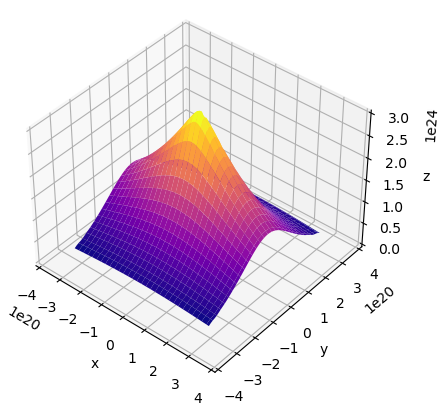

In [14]:
Z = Z.astype(float).reshape(60,60)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, cmap='plasma')
ax.set_xlabel('x') #to be constistent with our first convention (sorry for the mess)
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim3d(-4e20, 4e20)
ax.set_ylim3d(-4e20, 4e20)
ax.set_zlim3d(0, 3e24)
ax.view_init(40, -50)# rotate the axes (elevation angle, azimuthal angle)
plt.show()

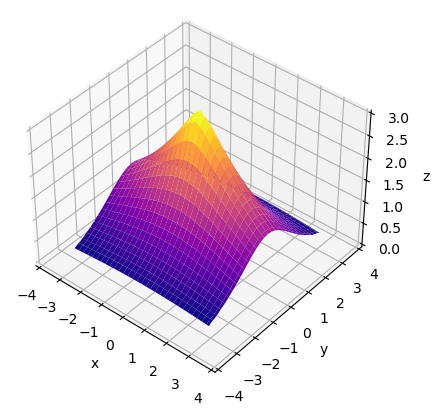

In [20]:
# Use order unity numbers to make the fit easier

X_ = X*1e-20
Y_ = Y*1e-20
Z_ = Z*1e-24

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X_, Y_, Z_, cmap='plasma')
ax.set_xlabel('x') #to be constistent with our first convention (sorry for the mess)
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim3d(-4, 4)
ax.set_ylim3d(-4, 4)
ax.set_zlim3d(0, 3)
ax.view_init(40, -50)# rotate the axes (elevation angle, azimuthal angle)
plt.show()

We choose to fit with the function
$$
a + b_{x}x^{2} + b_{y}y^{2} + c_{x}x^{4} + c_{xy}x^{2}y^{2} + c_{y}y^{4} 
+ d_{x}x^{8} + d_{xxy}x^{6}y^{2} + d_{xyy}x^{2}y^{6} + d_{y}y^{8}
$$

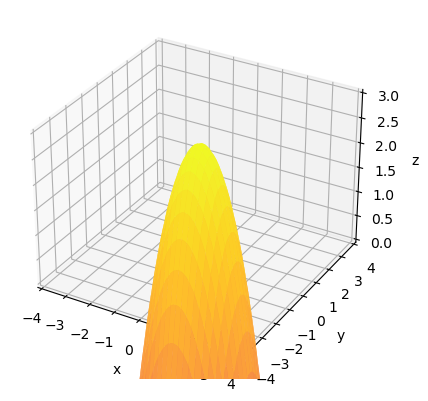

In [31]:
def Ne_fit_plot(x, y, a, bx, by, cx, cxy, cy, dx, dxxy, dxyy, dy):
    'In cm^{-2}'
    'x,y in m'
    
    return (a  + bx*x**2 + by*y**2 +
            cx*x**4 + cxy*x**2*y**2  + cy*y**4 + 
            + dx*x**8 + dxxy*x**6*y**2 + dxyy*x**2*y**6 + dy*y**8)

fig = plt.figure()
ax = fig.gca(projection='3d')
Z1 = Ne_fit_plot(X_ , Y_, 2.4, -1, -1, 0, 0, 0, 0, 0, 0, 0)
ax.plot_surface(X_, Y_, Z1, cmap='plasma')
ax.set_xlabel('x') 
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim3d(-4, 4)
ax.set_ylim3d(-4, 4)
ax.set_zlim3d(0, 3)
ax.view_init(30, -60)
plt.show()

In [32]:
def Ne_fit(X, a, bx, by, cx, cxy, cy, dx, dxxy, dxyy, dy):
    'In cm^{-2}'
    'x,y in m'
    x, y = X
    return (a  + bx*x**2 + by*y**2 +
            cx*x**4 + cxy*x**2*y**2  + cy*y**4 + 
            + dx*x**8 + dxxy*x**6*y**2 + dxyy*x**2*y**6 + dy*y**8)

In [33]:
x_data = np.vstack((X_.ravel(), Y_.ravel()))

In [34]:
p0 = [2.4, -1, -1, 0, 0, 0, 0, 0, 0, 0]

In [35]:
popt, pcov = curve_fit(Ne_fit, x_data, Z_.ravel(),p0)

In [36]:
perr = np.sqrt(np.diag(pcov))

for i in range(len(popt)):
    print(popt[i],'pm',perr[i])

2.6097948401367868 pm 0.005770445437826259
-0.22774519155427864 pm 0.003972510030493112
-0.6827643719764176 pm 0.0039725106939882595
0.011461620144323812 pm 0.0007139374584663794
0.038604933975971076 pm 0.0005687374712483726
0.06402064195225313 pm 0.000713937534939854
-1.2229850296299583e-05 pm 4.587511314128688e-06
-0.00010180661667109108 pm 5.2556642387995606e-06
-0.00022031847465987353 pm 5.255664056373741e-06
-0.0001791123488920905 pm 4.587511324250648e-06


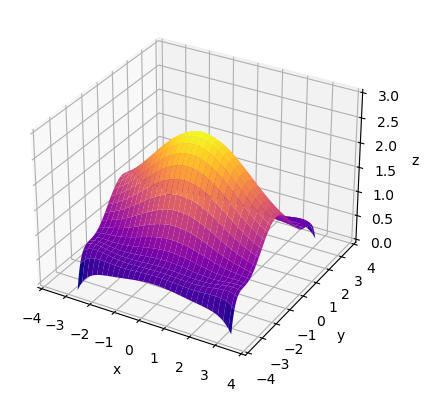

In [38]:
fig = plt.figure()
ax = fig.gca(projection='3d')
Z1 = Ne_fit_plot(X_ , Y_, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5], popt[6], popt[7], popt[8], popt[9])
ax.plot_surface(X_, Y_, Z1, cmap='plasma')
ax.set_xlabel('x') 
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim3d(-4, 4)
ax.set_ylim3d(-4, 4)
ax.set_zlim3d(0, 3)
ax.view_init(30, -60)
plt.show()